In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

In [3]:
class TrueCovariance:
    def __init__(self, bias=0):
        self.sig = None
        self.sig_i = None
        self.location_ = None
        self.bias = bias
        
    def fit(self, X):
        self.sig = np.cov(X.T, bias=self.bias)
        self.sig_i = np.linalg.inv(self.sig)
        self.location_ = X.mean(0)
        return self
        
    def mahalanobis(self, obso):
        c_obso = obso-self.location_
        mahalanobis_dist = np.sum(np.dot(c_obso,self.sig_i)*c_obso, 1)
        return mahalanobis_dist

# Graph out various types of Mahalanobis

### Generate data

In [4]:
n_samples = 50
n_outliers = int(n_samples*0.25)
n_features = 2


gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
gen_cov[1, 1] = 1.5
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)

### Add some outliers

In [5]:
outliers_cov = np.eye(n_features)
outliers_cov[0,0] = 5.
outliers_cov[1,1] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

### Fit the data for calculating

In [6]:
# fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov = MinCovDet().fit(X)

# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(X)

# compare against the true Covariance Matrix
true_cov = TrueCovariance().fit(X)

# Display results

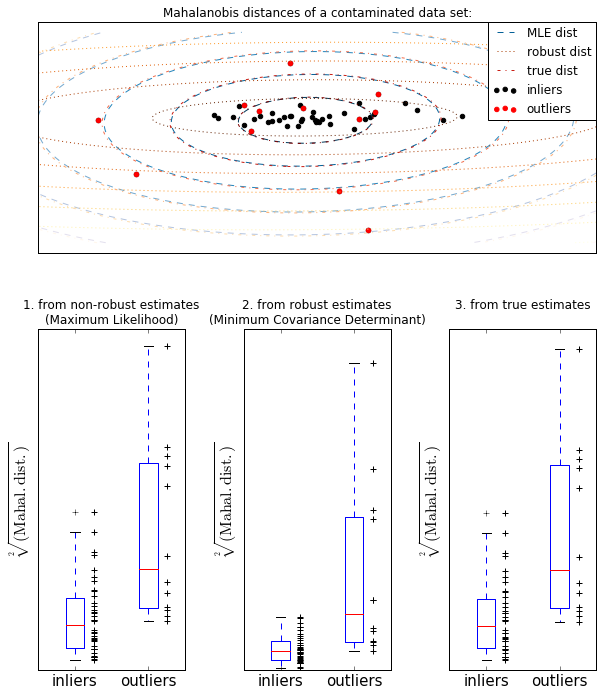

In [7]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=-.1, wspace=.4, top=.95, bottom=.05)

# Show data set
subfig1 = plt.subplot(3, 1, 1)
inlier_plot = subfig1.scatter(X[:, 0], X[:, 1],
                              color='black', label='inliers')
outlier_plot = subfig1.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],
                               color='red', label='outliers')
subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title("Mahalanobis distances of a contaminated data set:")

# Show contours of the distance functions
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = subfig1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')

mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, linestyles='dotted')

mahal_true_cov = true_cov.mahalanobis(zz)
mahal_true_cov = mahal_true_cov.reshape(xx.shape)
true_contour = subfig1.contour(xx, yy, np.sqrt(mahal_true_cov),
                                 cmap=plt.cm.OrRd_r, linestyles='dashdot')

subfig1.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
                true_contour.collections[1],
                inlier_plot, outlier_plot],
               ['MLE dist', 'robust dist', 'true dist', 'inliers', 'outliers'],
               loc="upper right", borderaxespad=0)
plt.xticks(())
plt.yticks(())

# Plot the scores for each point
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.5)
subfig2 = plt.subplot(2, 3, 4)
subfig2.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
subfig2.plot(1.26 * np.ones(n_samples - n_outliers),
             emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig2.plot(2.26 * np.ones(n_outliers),
             emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig2.set_ylabel(r"$\sqrt[2]{\rm{(Mahal. dist.)}}$", size=16)
subfig2.set_title("1. from non-robust estimates\n(Maximum Likelihood)")
plt.yticks(())

robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.5)
subfig3 = plt.subplot(2, 3, 5)
subfig3.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
                widths=.25)
subfig3.plot(1.26 * np.ones(n_samples - n_outliers),
             robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig3.plot(2.26 * np.ones(n_outliers),
             robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig3.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig3.set_ylabel(r"$\sqrt[2]{\rm{(Mahal. dist.)}}$", size=16)
subfig3.set_title("2. from robust estimates\n(Minimum Covariance Determinant)")
plt.yticks(())

true_mahal = true_cov.mahalanobis(X - true_cov.location_) ** (0.5)
subfig3 = plt.subplot(2, 3, 6)
subfig3.boxplot([true_mahal[:-n_outliers], true_mahal[-n_outliers:]],
                widths=.25)
subfig3.plot(1.26 * np.ones(n_samples - n_outliers),
             true_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig3.plot(2.26 * np.ones(n_outliers),
             true_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig3.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig3.set_ylabel(r"$\sqrt[2]{\rm{(Mahal. dist.)}}$", size=16)
subfig3.set_title("3. from true estimates\n")
plt.yticks(())

plt.show()

# Try to detect outliers

In [21]:
def DetectOutlier(X, stdd=1.0, method='robust'):
    sig = None
    if method == 'robust':
        # fit a Minimum Covariance Determinant (MCD) robust estimator to data
        sig = MinCovDet().fit(X)
    elif method == 'empirical':
        # compare estimators learnt from the full data set with true parameters
        sig = EmpiricalCovariance().fit(X)
    elif method == 'true':
        # compare against the true Covariance Matrix
        sig = TrueCovariance(bias=2).fit(X)
        
    MD = np.sqrt(sig.mahalanobis(X - sig.location_))
    print MD
    threshold = np.mean(MD)+(np.std(MD)*stdd)
    n = next(x[0] for x in enumerate(sorted(MD)) if x[1] > threshold)
    return (X[np.argsort(MD)][:n], X[np.argsort(MD)][-(len(MD)-n):])

### Generate data

In [9]:
n_samples = 5000
n_outliers = 10
n_features = 2

gen_cov = np.eye(n_features)
gen_cov[0, 0] = 7.
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)

### Add some outliers

In [10]:
outliers_cov = np.eye(n_features)
outliers_cov[1,1] = 11.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

In [12]:
# Uncomment if you want to read in some pre-generadata data from KMeans outlier
X = np.genfromtxt('t_data.csv', delimiter=',')

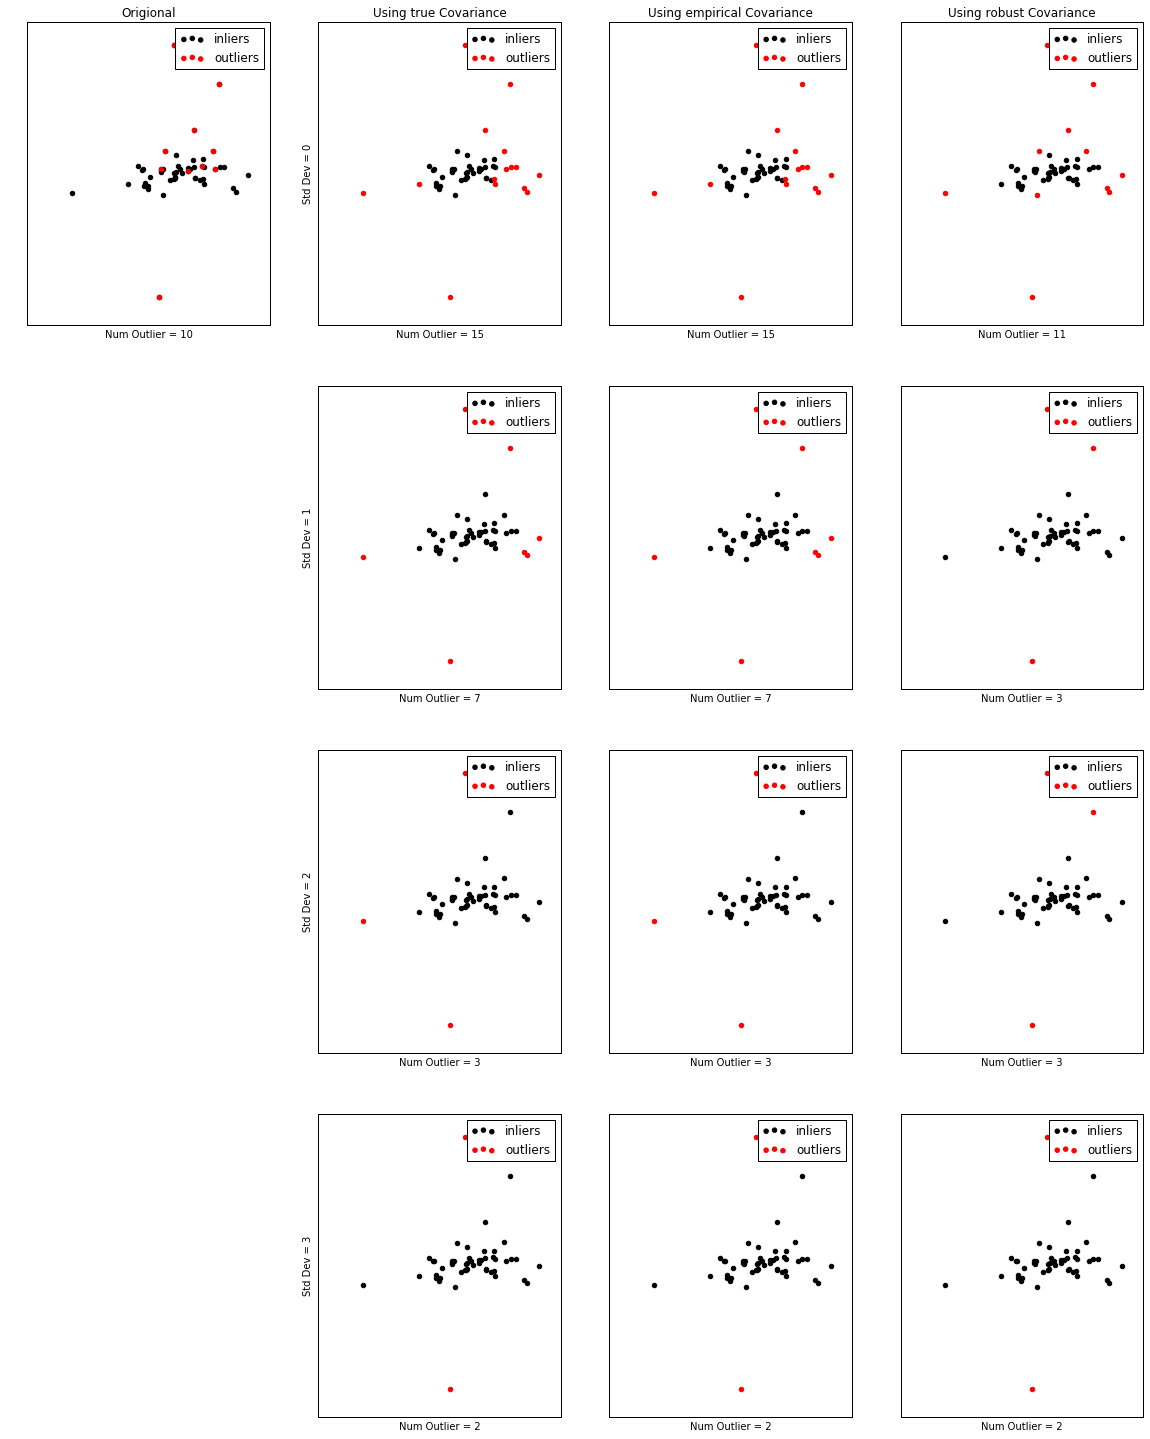

In [16]:
fig = plt.figure(figsize=(20,25))

subfig = plt.subplot(4, 4, 1)
subfig.scatter(X[:, 0], X[:, 1], color='black', label='inliers')
subfig.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:], color='red', label='outliers')
subfig.legend(loc='upper right')
subfig.set_title('Origional')
subfig.set_xlabel('Num Outlier = '+str(n_outliers))
plt.xticks(())
plt.yticks(())

for r, t in enumerate([0,1,2,3]):
    if r != 0:
        subfig = plt.subplot(4, 4, (4*r)+1)
        subfig.axis('off')
    for c, p in enumerate(['true', 'empirical', 'robust']):
        subfig = plt.subplot(4, 4, (4*r)+(c+2))
        m, o = DetectOutlier(X, t, p)
        subfig.scatter(m[:, 0], m[:, 1], color='black', label='inliers')
        subfig.scatter(o[:, 0], o[:, 1], color='red', label='outliers')
        subfig.legend(loc='upper right')
        if r == 0:
            subfig.set_title('Using '+p+' Covariance')
        if c == 0:
            subfig.set_ylabel('Std Dev = '+str(t))
        subfig.set_xlabel('Num Outlier = '+str(o.shape[0]))
        plt.xticks(())
        plt.yticks(())

In [22]:
m, o = DetectOutlier(X, 0, 'true')

[ 0.3603275   2.26861366  0.42575573  1.07452221  1.04834455  1.18221859
  1.60018516  0.94212674  0.39017922  0.32374436  2.3992197   0.88282132
  0.90940697  0.72186861  0.87678014  3.14735626  1.38325039  0.23409224
  0.92382957  0.91553439  0.882319    0.44587052  0.91277747  1.06572512
  0.22711241  0.39304298  0.30700314  0.64445311  0.24490155  0.83471823
  1.10494768  0.7402738   1.31095792  0.21408373  0.65733028  0.40179752
  1.74510117  0.57404928  0.30031471  2.58287354  0.31990595  1.46400337
  0.58762207  0.63971487  0.99473364  4.28091946  1.35426347  2.95571111
  4.11211133  1.37445225]
